# Topic Modelling

topic models automatically summarize large collections of documents to facilitate organization and management as well as search and recommendations.
Enables understanding of documents, to extent that the humans can interpret description of topics
TM mitigates <b>curse of dimensionality</b>; BOW often sparse vectors, thus resulting similiarity measure noisy. 

Initial topic modelling - applied linear algebra to reduce dimensionality (DTM). While effective, it is difficulat to evaluate the results of these models without benchmark model. In response, probabilistic models emerged that assume <b>an explicit document generation process and provide algorithms to reverse engineer this process to uncover the underlying topics </b>.

Example of models:
<li> Latent semantic indexing 
<li> Probabilistic latent semantic analysis (p-SLA) 
<li> Latent Dirichlet allocation (LDA)

![topic modelling](https://miro.medium.com/max/4800/1*cDwKSHmfp5awjqjobV707g.png)

## Latent Semantic Indexing
Goal to model relationship between documents and terms so that it could predict that a term should be associated with a document even though, because of the variability in word use, no such association is observed.
LSI uses linear algebra to find a given number k of latent topics by decomposing the DTM. Uses <b>singular value decomposition</b> , find the best lower-rank DTM approximation using k singular values and vectors. 

Implementation example with `sklearn`

Steps:
1. creating a train and (stratified) test set with 50
articles. 
2. we vectorize the data using TfidfVectorizer to obtain weighted DTM counts

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
from random import randint
import numpy as np
import pandas as pd

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [3]:
DATA_DIR = Path('../data/01_raw/')
path = DATA_DIR / 'bbc'
files = sorted(list(path.glob('**/*.txt')))
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

In [5]:
# Convert to dataframe
docs = pd.DataFrame(doc_list, columns=['Category', 'Heading', 'Article'])
docs = docs[docs['Category'] != 'Bbc']
docs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2225 entries, 0 to 2225
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2225 non-null   object
 1   Heading   2225 non-null   object
 2   Article   2225 non-null   object
dtypes: object(3)
memory usage: 69.5+ KB


In [6]:
docs.Category.value_counts()

Sport            511
Business         510
Politics         417
Tech             401
Entertainment    386
Name: Category, dtype: int64

Create Train Test

In [7]:
train_docs, test_docs = train_test_split(docs,
                                         stratify=docs.Category,
                                         test_size=50,
                                         random_state=42)

In [8]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [9]:
pd.Series(test_docs.Category).value_counts()

Sport            12
Business         11
Entertainment     9
Politics          9
Tech              9
Name: Category, dtype: int64

Vectorise train and test set

In [10]:
vectorizer = TfidfVectorizer(max_df=.25,
                             min_df=.01,
                             stop_words='english',
                             binary=False)
train_dtm = vectorizer.fit_transform(train_docs.Article)
train_dtm

<2175x2917 sparse matrix of type '<class 'numpy.float64'>'
	with 210043 stored elements in Compressed Sparse Row format>

In [11]:
test_dtm = vectorizer.transform(test_docs.Article)
test_dtm

<50x2917 sparse matrix of type '<class 'numpy.float64'>'
	with 4758 stored elements in Compressed Sparse Row format>

Get token count

In [12]:
train_token_count = train_dtm.sum(0).A.squeeze()
tokens = vectorizer.get_feature_names()
word_count = pd.Series(train_token_count,
                       index=tokens).sort_values(ascending=False)
word_count.head(10)

film          41.256270
government    38.808175
game          36.319726
best          36.093477
uk            36.082515
labour        32.496474
music         30.706548
000           30.276350
company       29.549555
number        29.153795
dtype: float64

## Latent Semantic Analysis

Using sklearn’s TruncatedSVD class that only computes the <u>k largest singular values</u> to reduce the dimensionality of the <u>document-term matrix</u>. The deterministic arpack algorithm delivers an exact solution but the default ‘randomized’ implementation is more efficient for large matrices.

We compute five topics to match the five categories, which explain only 5.4% of the total DTM variance so higher values would be reasonable.

In [13]:
n_components = 5
topic_labels = ['Topic {}'.format(i) for i in range(1, n_components + 1)]

In [14]:
svd = TruncatedSVD(n_components=n_components, n_iter=5, random_state=42)
svd.fit(train_dtm)

TruncatedSVD(n_components=5, random_state=42)

In [15]:
svd.singular_values_.round(3)

array([8.909, 5.718, 5.382, 5.044, 4.714])

In [16]:
svd.explained_variance_ratio_.sum().round(3)

0.054

Explore topics

LSI identifies a new orthogonal basis for the <u>document-term matrix</u> that reduces the rank to the number of desired topics.

The `.transform()` method of the trained svd object projects the documents into the new topic space that is the result of reducing the dimensionality of the document vectors and corresponds to the UTΣT transformation explained in the book.

In [17]:
train_doc_topics = svd.transform(train_dtm)
train_doc_topics.shape

(2175, 5)

Topic Weights for sample article

We can sample an article to view its location in the topic space. We draw a 'Politics' article that is most (positively) associated with topics 1 and 3:

In [18]:
i = randint(0, len(train_docs)) #not replicable.
(train_docs.iloc[i, :2].append(
    pd.Series(train_doc_topics[i], index=topic_labels)))

Category                       Entertainment
Heading     Oscar host Rock to keep it clean
Topic 1                             0.147814
Topic 2                            -0.118066
Topic 3                            -0.007938
Topic 4                             0.248766
Topic 5                            -0.024216
dtype: object

Average topic weight per category


In [19]:
train_result = pd.DataFrame(data=train_doc_topics,
                            columns=topic_labels,
                            index=train_docs.Category).round(3)
train_result

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
Category,,,,,
Entertainment,0.139,-0.072,-0.011,0.162,-0.019
Tech,0.161,0.035,-0.100,-0.028,0.176
Entertainment,0.138,-0.065,0.001,0.098,-0.046
Business,0.185,0.058,-0.078,-0.045,-0.092
Sport,0.170,-0.116,0.075,-0.034,-0.053
...,...,...,...,...,...
Politics,0.299,0.296,0.340,0.086,0.097
Politics,0.220,0.133,0.073,0.042,0.041
Sport,0.124,-0.117,0.066,-0.069,-0.055


In [20]:
train_result.groupby(level='Category').mean()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
Category,,,,,
Business,0.184399,0.063000,-0.098301,-0.052076,-0.115868
Entertainment,0.171029,-0.087944,-0.018432,0.168894,-0.027602
Politics,0.210610,0.148890,0.114223,0.028426,0.031123
Sport,0.177140,-0.142371,0.096930,-0.090138,-0.010391
Tech,0.190135,-0.011464,-0.126054,-0.012138,0.144612


Topic weights of most frequent words

In [21]:
topics = pd.DataFrame(svd.components_.T, index=tokens, columns=topic_labels)
topics.loc[word_count.head(10).index]

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
film,0.096117,-0.157755,-0.037131,0.456760,-0.108419
government,0.105821,0.158542,0.050579,0.000476,-0.032035
game,0.092472,-0.165604,0.074222,-0.112915,0.056594
best,0.088036,-0.148498,0.019054,0.264735,-0.091923
uk,0.092431,0.030233,-0.055868,0.041345,0.012776
labour,0.100164,0.237937,0.227080,0.071624,0.054642
music,0.078805,-0.050253,-0.114264,0.080930,0.140046
000,0.073360,0.029985,-0.044699,0.003032,-0.013678
company,0.067638,0.024084,-0.102071,-0.028465,-0.053378
number,0.070099,-0.039725,-0.019470,0.030363,0.003596


Most important words by topic

We can also display the words that are most closely associated with each topic (in absolute terms). The topics appear to capture some semantic information but are not clearly differentiated

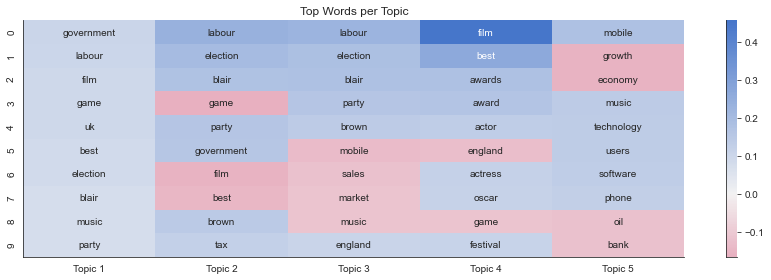

In [22]:
fig, ax = plt.subplots(figsize=(12, 4))
top_words, top_vals = pd.DataFrame(), pd.DataFrame()
for topic, words_ in topics.items():
    top10 = words_.abs().nlargest(10).index
    vals = words_.loc[top10].values
    top_vals[topic] = vals
    top_words[topic] = top10.tolist()
sns.heatmap(pd.DataFrame(top_vals),
            annot=top_words,
            fmt='',
            center=0,
            cmap=sns.diverging_palette(0, 255, sep=1, n=256),
            ax=ax)
ax.set_title('Top Words per Topic')
sns.despine()
fig.tight_layout()

## Strengths and weakness
The benefits of LSI include the <i>removal of noise and mitigation of the curse of dimensionality</i>, while also capturing some semantics and performing a clustering of both documents and terms.

However, the results of <i>LSI are difficult to interpret because topics are word vectors with both positive and negative entries</i>. In addition, there is no underlying model that would permit the evaluation of fit and provide guidance when selecting the number of dimensions or topics.